# Inference with sampling for flu data

## Flu case incidences

In [65]:
import numpy as np
import pandas as pd

import seirmo as se
from seirmo import plots

# read french flu data
flu_data = se.DatasetLibrary().french_flu()

# extract data of roughly one season (estimated)
flu_data = flu_data.loc[:30,:]
times = flu_data['time_index']

# normalise incidence number by its maximum
flu_data['inc'] = flu_data['inc'] / 100000 # np.max(flu_data['inc'])

In [66]:
# Plot incidences data
plot = plots.IncidenceNumberPlot()
plot.add_data(flu_data, time_key='time_index', inc_key='inc')
plot.show()

# Using pints

In [67]:
import pints

class SEIRModel(pints.ForwardModel):
    def __init__(self):
        super(SEIRModel, self).__init__()

        self._model = se.SEIRModel()
    
    def n_outputs(self):
        # Returns number of model outputs.
        # Returns only incidence number, in line with the flu data
        return 1

    def n_parameters(self):
        # Returns number of parameters, i.e. 4 initial condition and 3 parameters.
        return 5
    
    def simulate(self, parameters, times):
        parameters = np.insert(parameters, 3, 0.1)
        parameters = np.insert(parameters, 6, 0.1)
        # parameters = np.exp(parameters)
        output = self._model.simulate(parameters=parameters, times=times, return_incidence=True)
        n_incidence = output[:,4]

        return n_incidence

In [68]:
# Create log-likelihood
pints_model = SEIRModel()
problem = pints.SingleOutputProblem(pints_model, times, flu_data['inc'])
log_likelihood = pints.GaussianLogLikelihood(problem)

In [69]:
log_prior = pints.ComposedLogPrior(
    pints.TruncatedGaussianLogPrior(20, 5, 0, np.inf),
    pints.TruncatedGaussianLogPrior(0.3, 1, 0, np.inf),
    pints.TruncatedGaussianLogPrior(0.3, 1, 0, np.inf),
    pints.TruncatedGaussianLogPrior(0.3, 1, 0, np.inf),
    pints.TruncatedGaussianLogPrior(1, 1, 0, np.inf),
    pints.TruncatedGaussianLogPrior(1, 1, 0, np.inf),
    pints.TruncatedGaussianLogPrior(0, 1, 0, np.inf)
)

# log_prior = pints.UniformLogPrior(
#     [0, 0, 0, 0, 0, 0],
#     [1, 1, 1, 1, 1, 1]
# )


In [70]:
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

In [71]:
# initial parameter guess
# parameter_guess = np.log(np.array([0.7, 0.5, 0.5, 0.5, 0.5, 0.5, 0.1, 0.1]))

In [75]:
# xs = log_prior.sample(3)
xs = np.array([[10, 0.6, 0.2, 0.1, 0.7, 0.3, 0.01]])

In [73]:
xs

array([10.  ,  0.6 ,  0.2 ,  0.1 ,  0.7 ,  0.3 ,  0.01])

In [76]:
# parameter transformation
transform = pints.LogTransformation(n_parameters=7)
mcmc = pints.MCMCController(log_posterior, 1, xs, method=pints.HaarioBardenetACMC, transform=transform)

# mcmc.set_max_iterations(4000)

chains = mcmc.run()

Using Haario-Bardenet adaptive covariance MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Time m:s
0     1      0          0:00.1
1     2      0          0:00.1
2     3      0.333      0:00.1
3     4      0.5        0:00.1
20    21     0.571      0:00.7
40    41     0.415      0:01.3
60    61     0.442623   0:01.8
80    81     0.444      0:02.4
100   101    0.465      0:03.3
120   121    0.496      0:03.9
140   141    0.496      0:04.5
160   161    0.497      0:05.0
180   181    0.492      0:05.6
Initial phase completed.
200   201    0.488      0:06.0
220   221    0.475      0:06.4
240   241    0.481      0:06.9
260   261    0.48659    0:07.5
280   281    0.488      0:07.9
300   301    0.468      0:08.4
320   321    0.464      0:08.8
340   341    0.455      0:09.3
360   361    0.44       0:10.0
380   381    0.425      0:10.4
400   401    0.414      0:12.6
420   421    0.399      0:15.9
440   441    0.397      0:17.3
460   461    0.386      0:21.9
480   481  

KeyboardInterrupt: 

# Pints' diagnostic plots

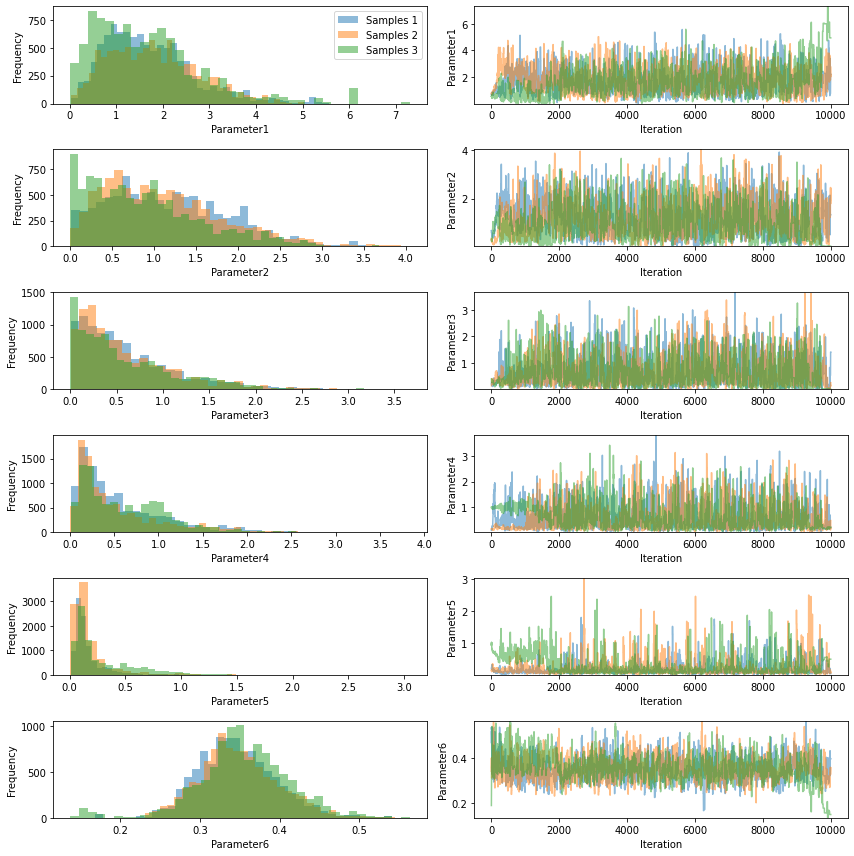

In [48]:
import pints.plot
import matplotlib.pyplot as plt

pints.plot.trace(chains)
plt.show()

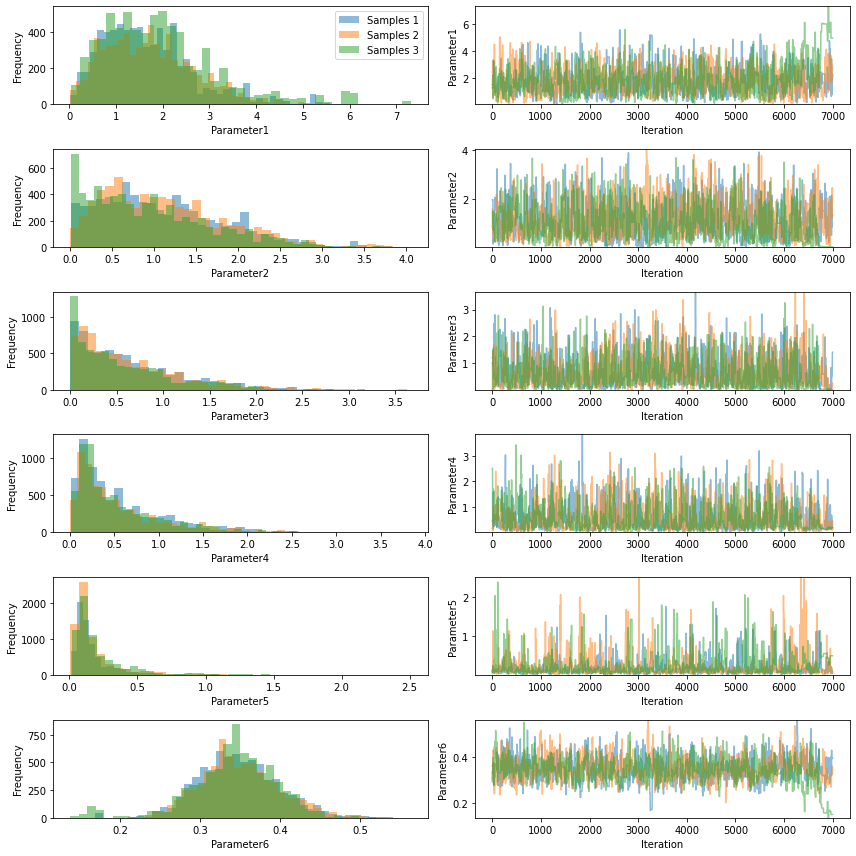

In [49]:
pints.plot.trace(chains[:, 3000:, :])
plt.show()

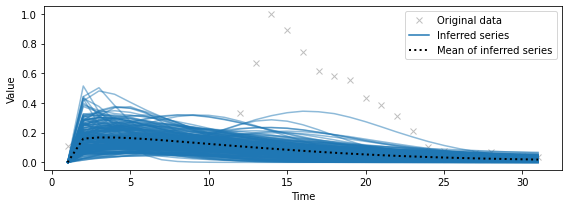

In [54]:
pints.plot.series(chains[0, 3000:], problem)
plt.show()

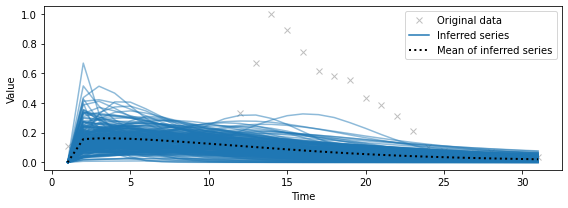

In [51]:
pints.plot.series(chains[1, 3000:], problem)
plt.show()

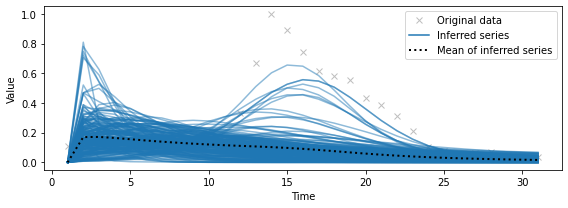

In [52]:
pints.plot.series(chains[2, 3000:], problem)
plt.show()